In [37]:
from IPython.display import display
from notebooks.util.long_memory_utils import *
from liquidity.util.utils import compute_returns, get_agg_features

from hurst_exponent.util.utils import augmented_dickey_fuller

In [2]:
# Automatically reload changes in package dependencies
%load_ext autoreload
%autoreload 2

In [3]:
# Number of events to use
EVENTS_RANGE = 100000

# Number of lags for the ACF
ACF_RANGE = 1001

# Lag/window size for Hurst
LAG = 100

## Load raw sample data

In [6]:
# Load raw sample data  from CSV
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'APPL']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')
acf_data_dir = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'long_memory')


stock_dfs = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2016-R1.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_dfs[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_dfs['TSLA']
amzn_raw_df = stock_dfs['AMZN']
nflx_raw_df = stock_dfs['NFLX']
msft_raw_df = stock_dfs['MSFT']
ebay_raw_df = stock_dfs['EBAY']
appl_raw_df = stock_dfs['APPL']

In [7]:
display(tsla_raw_df)

,Unnamed: 0,event_timestamp,trade_sign,side,lob_action,order_executed,execution_price,execution_size,ask,bid,midprice,ask_volume,bid_volume,price_changing,midprice_change,R1,norm_trade_volume
0,0,2016-01-04 10:30:02.487834868,-1,BID,REMOVE,True,221.36,100,221.46,221.36,221.410,100.0,100.0,True,0.000,-0.000,0.708122
1,1,2016-01-04 10:30:02.594369706,-1,BID,REMOVE,True,221.36,100,221.46,221.36,221.410,100.0,100.0,True,0.000,-0.000,0.708122
2,2,2016-01-04 10:30:02.602151380,-1,BID,REMOVE,True,221.36,100,221.46,221.36,221.410,200.0,100.0,True,-0.095,0.095,0.708122
3,3,2016-01-04 10:30:02.627167275,-1,BID,REMOVE,True,221.27,25,221.36,221.27,221.315,200.0,25.0,True,-0.010,0.010,0.177031
4,4,2016-01-04 10:30:02.895123534,-1,BID,REMOVE,True,221.25,100,221.36,221.25,221.305,100.0,100.0,True,-0.090,0.090,0.708122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757587,757587,2016-12-30 14:57:34.003070849,-1,BID,REMOVE,True,212.66,78,212.71,212.66,212.685,100.0,78.0,True,-0.045,0.045,0.523301
757588,757588,2016-12-30 14:57:49.675498708,1,ASK,REMOVE,True,212.70,100,212.70,212.58,212.640,100.0,3.0,True,0.015,0.015,0.764442
757589,757589,2016-12-30 14:57:50.825570371,1,ASK,REMOVE,True,212.73,118,212.73,212.58,212.655,118.0,3.0,True,-0.005,-0.005,0.902041
757590,757590,2016-12-30 14:58:02.190130229,1,ASK,REMOVE,True,212.72,100,212.72,212.58,212.650,100.0,3.0,True,0.035,0.035,0.764442


# The Long Memory of Orderflow (Trades)

To determine if a random process exhibits long memory, we take the following approach:

1. **Infer an Autocorrelation Function (ACF):** Start by inferring the ACF from a finite return sample.

2. **Fit a Power-law to the ACF:** Use the inferred ACF to fit a power-law.

3. **Estimate Hurst Exponent:** Use standard and generalized hurst on cumulative sum of raw series.

## 1. Return magnitudes

In [10]:
# Return magnitude (volatility)
tsla_returns = compute_returns(tsla_raw_df)['returns']
msft_returns = compute_returns(msft_raw_df)['returns']
amzn_returns = compute_returns(amzn_raw_df)['returns']
nflx_returns = compute_returns(nflx_raw_df)['returns']
ebay_returns = compute_returns(ebay_raw_df)['returns']
appl_returns = compute_returns(appl_raw_df)['returns']

return_magnitudes = {
  'TSLA': abs(tsla_returns),
  'MSFT': abs(msft_returns),
  'AMZN': abs(amzn_returns),
  'NFLX': abs(nflx_returns),
  'EBAY': abs(ebay_returns),
  'APPL': abs(appl_returns)
}
# Update the dictionary to only keep the first EVENTS_RANGE items
# returns_magnitudes = {stock: data.head(EVENTS_RANGE) for stock, data in return_magnitudes.items()}

In [9]:
# ADF test
for stock, data in return_magnitudes.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -29.68
p-value: 0.00,
N: 99931, 
critical values: {'1%': -3.4304154398333235, '5%': -2.861568923380865, '10%': -2.5667853949035773}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -42.01
p-value: 0.00,
N: 99957, 
critical values: {'1%': -3.43041542281121, '5%': -2.861568915857441, '10%': -2.5667853908991076}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -36.67
p-value: 0.00,
N: 99945, 
critical values: {'1%': -3.4304154306664696, '5%': -2.8615689193293044, '10%': -2.5667853927470654}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -30.86
p-value: 0.00,
N: 99932, 
critical values: {'1%': -3.430415439178463, '5%': -2.8615689230914305, '10%': -2.566785394749521}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


EBAY
A

### 1.2. Return magnitude ACF

In [11]:
# Linear ACF
volatility_linear_acf_filename = f"{acf_data_dir}/mo_volatility_linear_acfs.pkl"
volaitlity_linear_acfs = compute_acfs(filename=volatility_linear_acf_filename, data=return_magnitudes, option='linear')
print(volaitlity_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


In [12]:
# Nonlinear ACF
volatility_nonlinear_acf_filename = f"{acf_data_dir}/mo_volatility_nonlinear_acfs.pkl"
volatility_nonlinear_acfs = compute_acfs(filename=volatility_nonlinear_acf_filename, data=return_magnitudes, option='nonlinear')
print(volatility_nonlinear_acfs.keys())

/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multipl

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


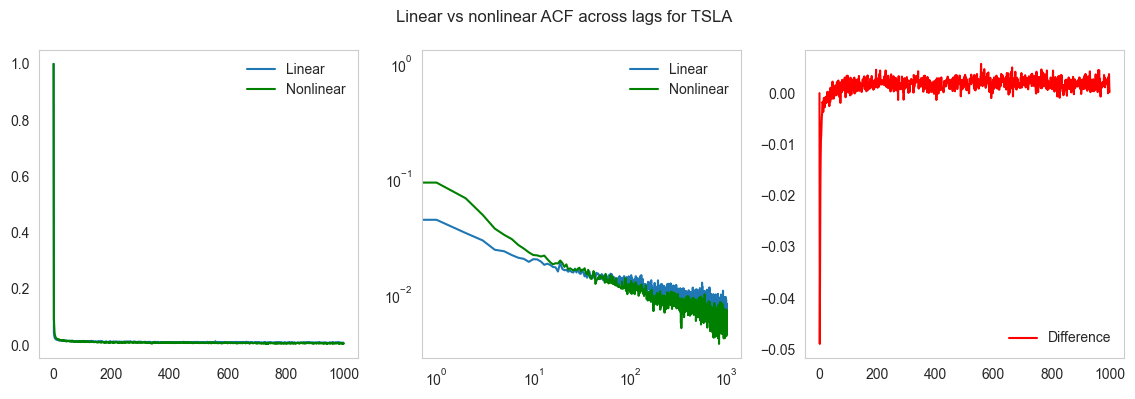

TSLA Max difference: 0.005706750712218543


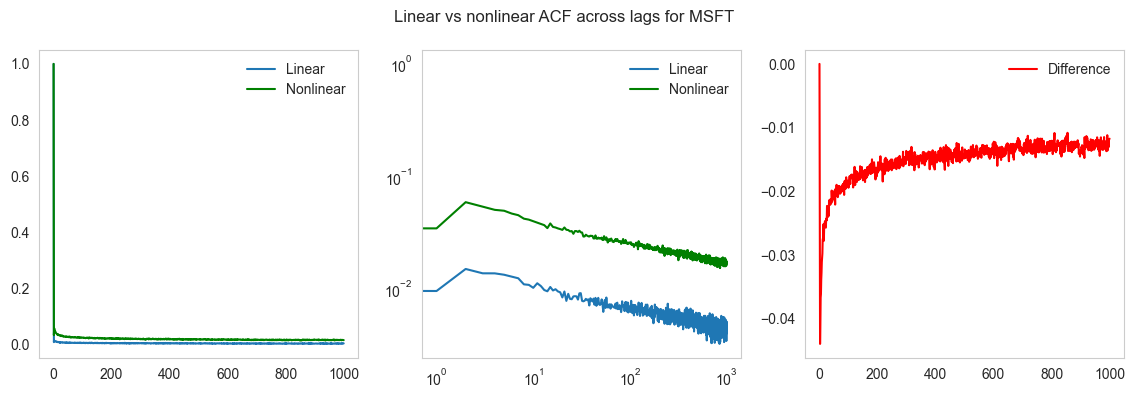

MSFT Max difference: 1.1102230246251565e-16


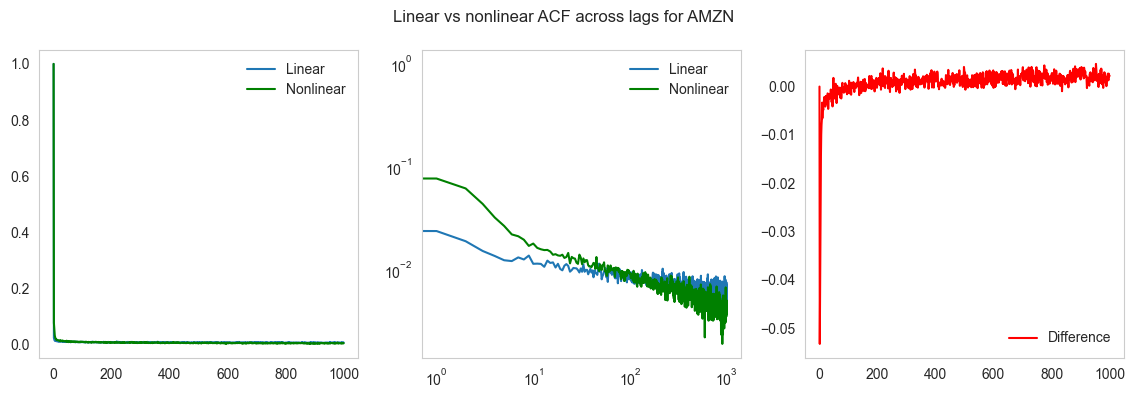

AMZN Max difference: 0.004695065724526252


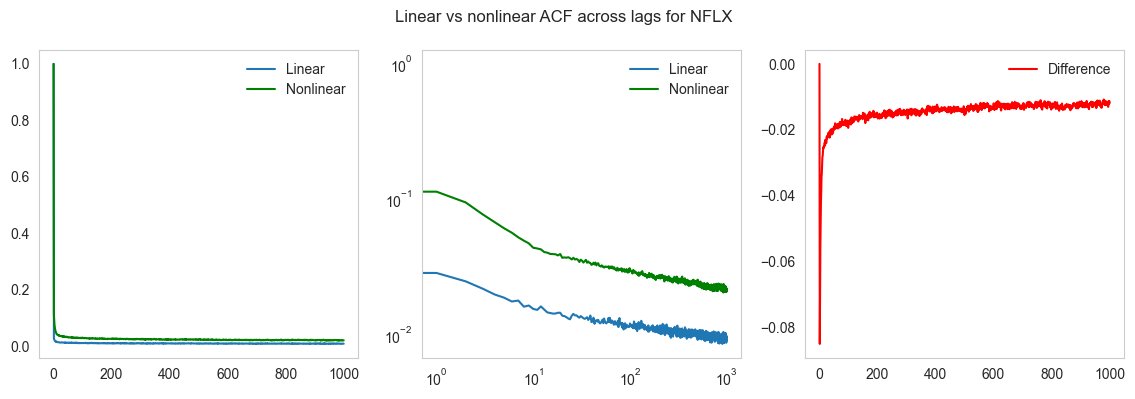

NFLX Max difference: 0.0


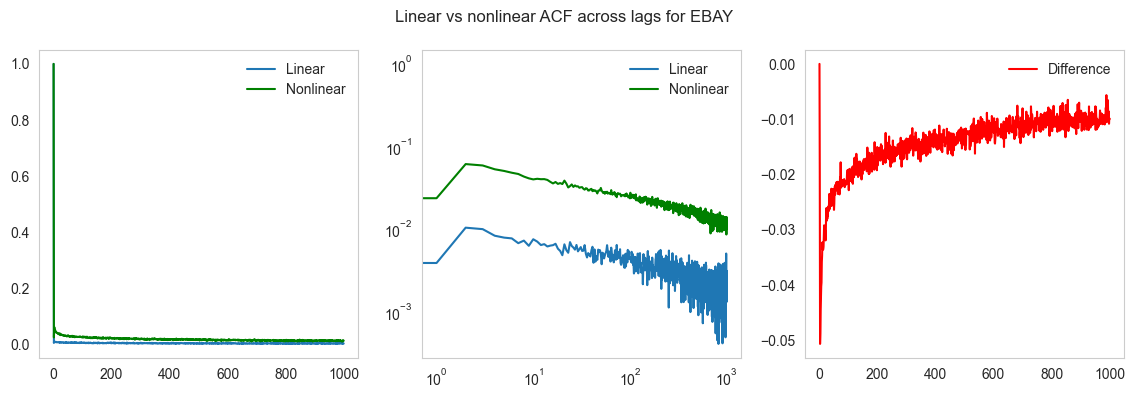

EBAY Max difference: 1.1102230246251565e-16


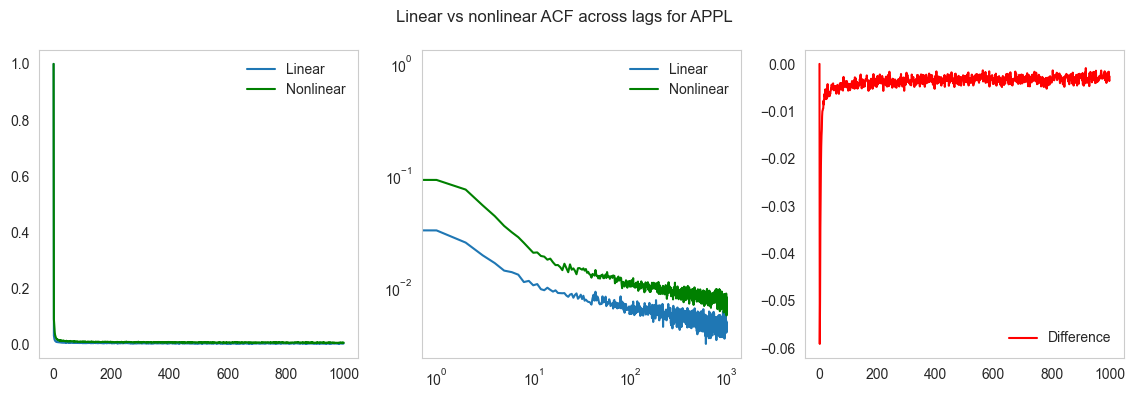

APPL Max difference: 0.0


In [14]:
for stock_name in volaitlity_linear_acfs.keys():
    plot_acf_difference(stock_name, volaitlity_linear_acfs, volatility_nonlinear_acfs)

### 1.3. Fit power law distribution

In [15]:
# Load the pre-computed ACFs
# 1. Construct values for x- and y-axis of our ACF
def construct_xy(sample: pd.Series, name: str) -> pd.DataFrame:
    y_values = list(sample)
    if len(sample) != len(y_values):
        raise ValueError(f"Sample sizes mismatch for {name}.")

    xy_df = pd.DataFrame({
        'x_values': range(1, len(y_values) + 1),
        'y_values': y_values
    })

    return xy_df

volatility_acf_values = {}

for stock, data in volatility_nonlinear_acfs.items():
    volatility_acf_values[stock] = construct_xy(data, stock)

In [16]:
# Using volatility_nonlinear_acfs
volatility_fit_results_list = []
volatility_fit_objects = {}  # Dictionary to store fit objects

for stock, data in volatility_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data)
    if fit_dict:
        volatility_fit_results_list.append(fit_dict)
        volatility_fit_objects[stock] = fit_obj  # Store the fit object

volatility_acf_fit_results = pd.DataFrame(volatility_fit_results_list)
display(volatility_acf_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0469176...",4,5.0,0.124373,-13816.385521,9.803333,0.901515,-0.299654,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0611851...",3,4.0,0.053106,-14054.993950,3.152123,0.959010,-0.187905,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0441012...",3,4.0,0.128257,-13747.088683,11.866032,0.872422,-0.344441,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0574695...",9,10.0,0.044355,-14430.813882,2.152771,0.961681,-0.144089,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1416698...",171,172.0,0.114458,-11060.519029,7.067004,0.819213,-0.361047,EBAY


In [17]:
avg_alpha = volatility_acf_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -0.2550737429939604


In [18]:
volatility_fit_objects.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])

### 1.3.Volatility Hurst Exponents

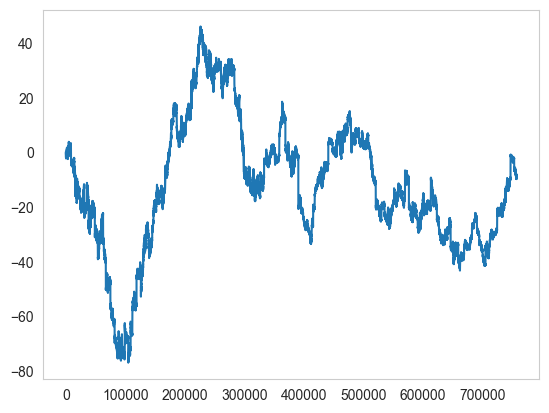

In [19]:
# Compute cumsum of return magnitude (volatility)
tsla_cum_returns = compute_returns(tsla_raw_df)['cumsum_returns']
amzn_cum_returns = compute_returns(msft_raw_df)['cumsum_returns']
nflx_cum_returns = compute_returns(amzn_raw_df)['cumsum_returns']
msft_cum_returns = compute_returns(nflx_raw_df)['cumsum_returns']
ebay_cum_returns = compute_returns(ebay_raw_df)['cumsum_returns']
appl_cum_returns = compute_returns(appl_raw_df)['cumsum_returns']

cumsum_return_magnitudes = {
  'TSLA': abs(tsla_cum_returns),
  'MSFT': abs(amzn_cum_returns),
  'AMZN': abs(nflx_cum_returns),
  'NFLX': abs(msft_cum_returns),
  'EBAY': abs(ebay_cum_returns),
  'APPL': abs(appl_cum_returns)
}
# Update the dictionary to only keep the first EVENTS_RANGE items
cumsum_return_magnitudes = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_return_magnitudes.items()}
x = list(range(1, len(tsla_cum_returns)+1))
plt.plot(x, tsla_cum_returns)
plt.grid(False)
plt.show()

#### Standard Hurst

In [20]:
# Standard Hurst
method = 'standard'
volatility_fit_results_list = []
volatility_fit_objects = {}

for stock, data in cumsum_return_magnitudes.items():
    fit_dict, fit = compute_hurst_exponent('volatility', stock, data, method=method)
    if fit_dict:
        volatility_fit_results_list.append(fit_dict)
        volatility_fit_objects[(stock, method, 'volatility')] = fit

volatility_std_hurst_fit_results = pd.DataFrame(volatility_fit_results_list)
display(volatility_std_hurst_fit_results.head(10))

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1141309...",1,1.0,0.022222,-3060.531397,0.705257,0.999242,0.508566,TSLA,volatility
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0091853...",1,1.0,0.031746,-4742.107703,0.568725,0.999387,0.500278,MSFT,volatility
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.2410894...",1,1.0,0.028571,-2793.671387,0.568011,0.999626,0.513894,AMZN,volatility
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0370560...",1,1.0,0.031746,-3639.012967,0.954800,0.998873,0.509327,NFLX,volatility
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0141472...",1,1.0,0.022222,-4732.753321,0.428042,0.999742,0.503457,EBAY,volatility
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0728448...",1,1.0,0.031746,-3403.389578,0.792365,0.999273,0.494300,APPL,volatility


In [21]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = volatility_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.5049703015043472


#### Generalized Hurst

In [22]:
# Generalized Hurst
method = 'generalized'
volatility_fit_results_list = []
volaility_fit_objects = {}

for stock, data in cumsum_return_magnitudes.items():
    fit_dict, fit = compute_hurst_exponent('volatility', stock, data, method=method)
    if fit_dict:
        volatility_fit_results_list.append(fit_dict)
        volaility_fit_objects[(stock, method, 'volatility')] = fit

volatility_gen_hurst_fit_results = pd.DataFrame(volatility_fit_results_list)
display(volatility_gen_hurst_fit_results.head())

/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/po

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0428210...",1,1.0,0.012698,-4001.599265,0.602724,0.999895,0.597551,TSLA,volatility
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0046186...",5,2.0,0.012862,-5532.075998,0.404699,0.999887,0.536231,MSFT,volatility
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0846554...",21,7.0,0.013559,-3789.402919,0.209535,0.999967,0.589137,AMZN,volatility
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0200984...",1,1.0,0.022222,-4333.740356,0.927593,0.999711,0.544262,NFLX,volatility
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0038629...",1,1.0,0.012698,-5784.537697,0.397633,0.999949,0.584942,EBAY,volatility


In [23]:
# Generalized Hurst statistic across stocks
min_hurst_gen = volatility_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = volatility_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = volatility_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = volatility_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.536230500670982
Max Generalized Hurst: 0.5975507848786287
Average Generalized Hurst: 0.5676782979428071
Standard_dev Generalized Hurst: 0.025987479483524967


## 2. Orderflow

##  2.1. Signs

In [24]:
# Signed orderflow
signed_orderflow = {
  'TSLA': tsla_raw_df['trade_sign'],
  'MSFT': msft_raw_df['trade_sign'],
  'AMZN': amzn_raw_df['trade_sign'],
  'NFLX': nflx_raw_df['trade_sign'],
  'EBAY': ebay_raw_df['trade_sign'],
  'APPL': appl_raw_df['trade_sign']
}
# Update the dictionary to only keep the first EVENTS_RANGE items
signed_orderflow = {stock: data.head(EVENTS_RANGE) for stock, data in signed_orderflow.items()}

### Stationarity Test

In [25]:
# ADF test
for stock, data in signed_orderflow.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -30.33
p-value: 0.00,
N: 99931, 
critical values: {'1%': -3.4304154398333235, '5%': -2.861568923380865, '10%': -2.5667853949035773}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -46.94
p-value: 0.00,
N: 99964, 
critical values: {'1%': -3.4304154182298467, '5%': -2.8615689138325724, '10%': -2.566785389821337}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -28.99
p-value: 0.00,
N: 99934, 
critical values: {'1%': -3.4304154378687812, '5%': -2.8615689225125784, '10%': -2.5667853944414167}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -39.78
p-value: 0.00,
N: 99959, 
critical values: {'1%': -3.430415421502184, '5%': -2.861568915278878, '10%': -2.5667853905911575}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


EBAY

### 2.1. Signs ACF

In [26]:
# Linear ACF
signs_linear_acf_filename = f"{acf_data_dir}/mo_signs_acfs.pkl"
signs_linear_acfs = compute_acfs(filename=signs_linear_acf_filename, data=signed_orderflow, option='linear')
print(signs_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


In [27]:
# Nonlinear ACF
signs_nonlinear_acf_filename = f"{acf_data_dir}/mo_signs_nonlinear_acfs.pkl"
signs_nonlinear_acfs = compute_acfs(filename=signs_nonlinear_acf_filename, data=signed_orderflow, option='nonlinear')
print(signs_nonlinear_acfs.keys())

/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


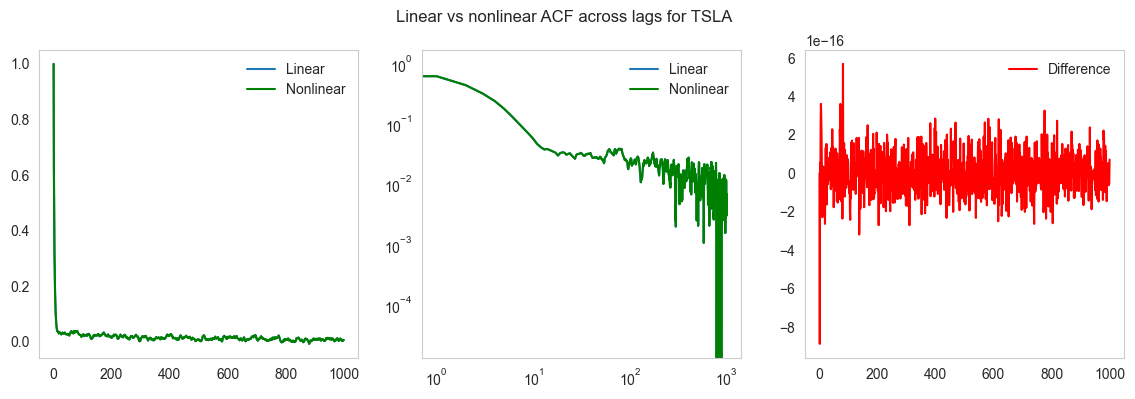

TSLA Max difference: 5.689893001203927e-16


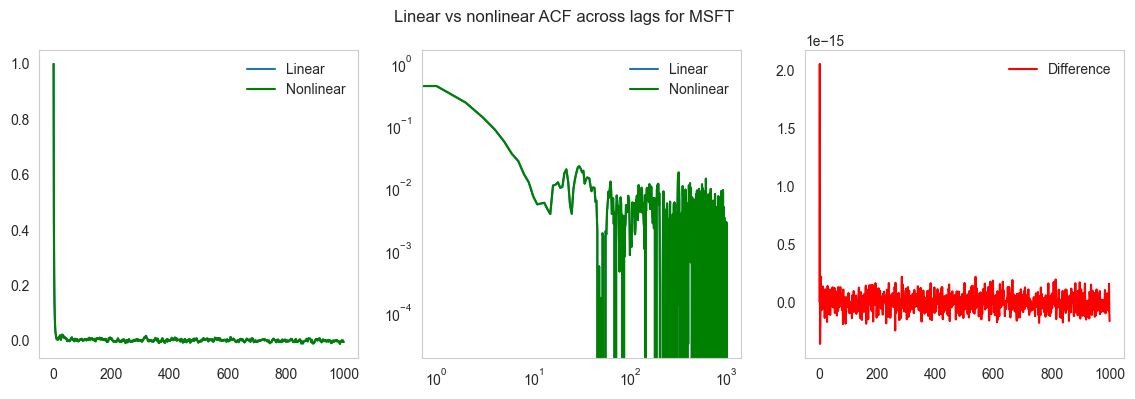

MSFT Max difference: 2.0539125955565396e-15


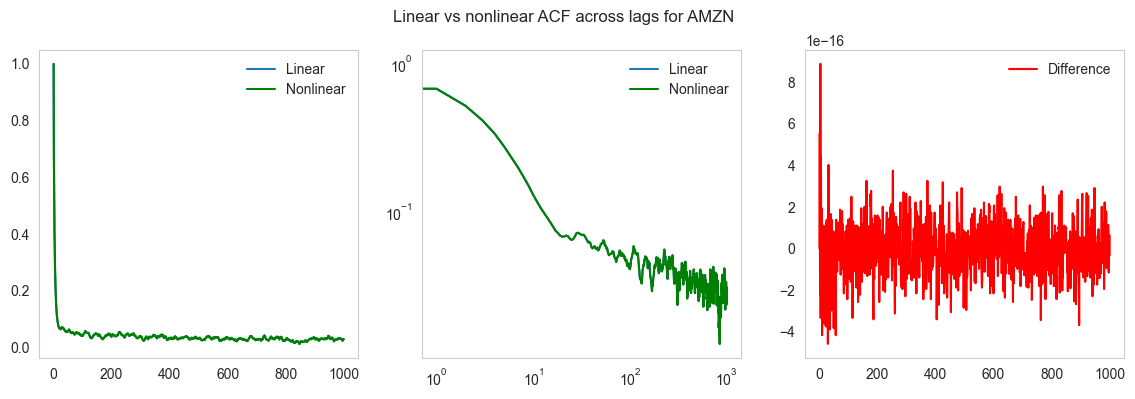

AMZN Max difference: 8.881784197001252e-16


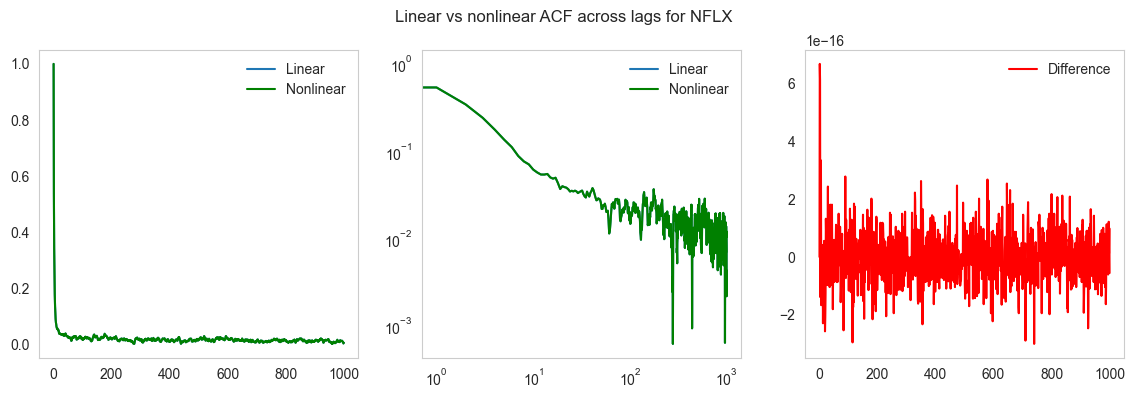

NFLX Max difference: 6.661338147750939e-16


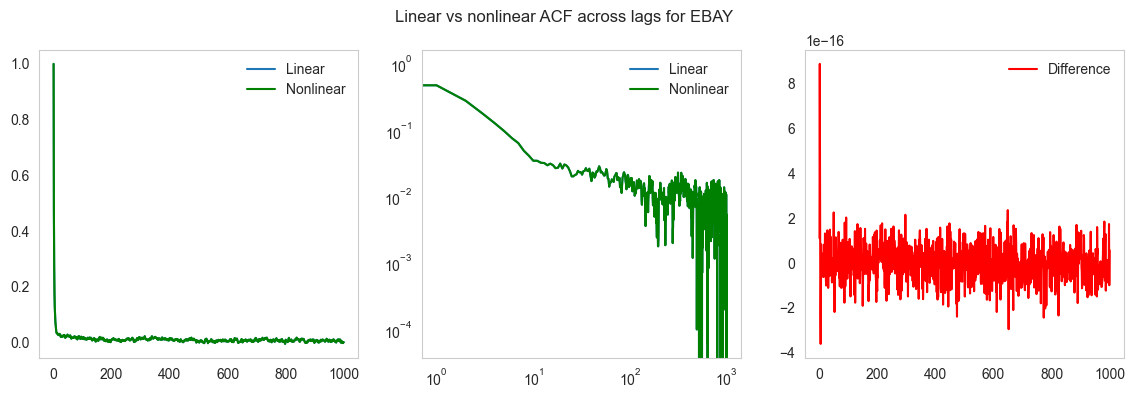

EBAY Max difference: 8.881784197001252e-16


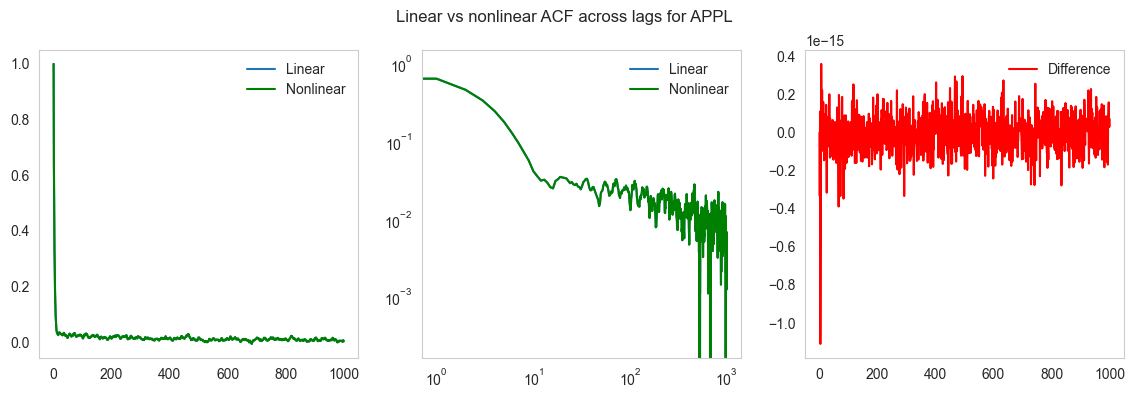

APPL Max difference: 3.608224830031759e-16


In [28]:
for stock_name in signs_linear_acfs.keys():
    plot_acf_difference(stock_name, signs_linear_acfs, signs_nonlinear_acfs)

### 2.2. Fit power law distribution

In [29]:
# Load the pre-computed ACFs
# 1. Construct values for x- and y-axis of our ACF
def construct_xy(sample: pd.Series, name: str) -> pd.DataFrame:
    y_values = list(sample)
    if len(sample) != len(y_values):
        raise ValueError(f"Sample sizes mismatch for {name}.")

    xy_df = pd.DataFrame({
        'x_values': range(1, len(y_values) + 1),
        'y_values': y_values
    })

    return xy_df

signs_acf_values = {}

for stock, data in signs_nonlinear_acfs.items():
    signs_acf_values[stock] = construct_xy(data, stock)

In [30]:
# Using signs_nonlinear_acfs
signs_fit_results_list = []
signs_fit_objects = {}  # Dictionary to store fit objects

for stock, data in signs_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data)
    if fit_dict:
        signs_fit_results_list.append(fit_dict)
        signs_fit_objects[stock] = fit_obj  # Store the fit object

signs_acf_fit_results = pd.DataFrame(signs_fit_results_list)
display(signs_acf_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.2015996...",5,6.0,0.265060,-9921.357936,121.588001,0.645345,-0.455444,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0945939...",5,6.0,0.397590,-10800.017161,183.608976,0.269595,-0.658191,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.2040354...",7,8.0,0.127767,-9899.655224,13.566301,0.748624,-0.297939,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1586954...",5,6.0,0.210843,-10310.252602,37.879296,0.658827,-0.400643,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1478540...",4,5.0,0.235707,-10561.361346,127.736905,0.628937,-0.469880,EBAY


In [31]:
avg_alpha = signs_acf_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -0.45622801749058167


### 2.3. Signed Orderflow Hurst Exponents

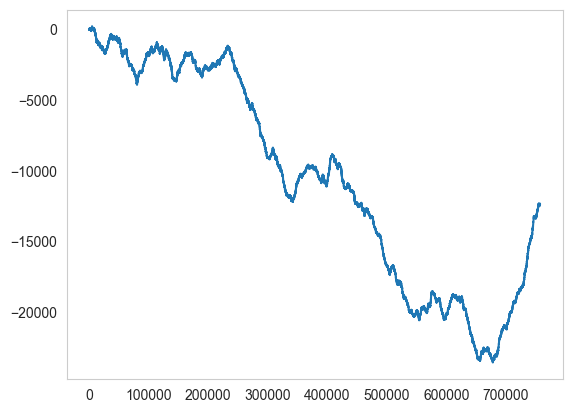

In [32]:
# Compute cumsum of signed orderflow
cumsum_signed_orderflow = {
  'TSLA': tsla_raw_df['trade_sign'].cumsum(),
  'MSFT': msft_raw_df['trade_sign'].cumsum(),
  'AMZN': amzn_raw_df['trade_sign'].cumsum(),
  'NFLX': nflx_raw_df['trade_sign'].cumsum(),
  'EBAY': ebay_raw_df['trade_sign'].cumsum(),
  'APPL': appl_raw_df['trade_sign'].cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
cumsum_signed_orderflow = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_signed_orderflow.items()}
tsla_cumsum_signs = tsla_raw_df['trade_sign'].cumsum()
x = list(range(1, len(tsla_cumsum_signs)+1))
plt.plot(x, tsla_cumsum_signs)
plt.grid(False)

#### Standard Hurst

In [33]:
# Standard Hurst
method = 'standard'
signs_fit_results_list = []
signs_fit_objects = {}

for stock, data in cumsum_signed_orderflow.items():
    fit_dict, fit = compute_hurst_exponent('signs', stock, data, method=method)
    if fit_dict:
        signs_fit_results_list.append(fit_dict)
        signs_fit_objects[(stock, method, 'signs')] = fit

signs_std_hurst_fit_results = pd.DataFrame(signs_fit_results_list)
display(signs_std_hurst_fit_results.head(10))

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.3896497...",8,3.0,0.022727,-1062.620331,0.965688,0.999353,0.651344,TSLA,signs
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.3149070...",8,3.0,0.032468,-1310.658731,0.742499,0.999349,0.584641,MSFT,signs
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.3574943...",8,3.0,0.022727,-1109.508476,0.863201,0.999662,0.703758,AMZN,signs
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.2580985...",1,1.0,0.022222,-1315.972826,1.020392,0.999694,0.664452,NFLX,signs
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.1734121...",1,1.0,0.022222,-1199.432471,1.147596,0.999421,0.652387,EBAY,signs
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.4642262...",11,4.0,0.022951,-1128.139064,0.845695,0.999451,0.636417,APPL,signs


In [34]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = signs_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.6488332737158965


#### Generalized Hurst

In [35]:
# Generalized Hurst
method = 'generalized'
signs_fit_results_list = []
signs_fit_objects = {}

for stock, data in cumsum_signed_orderflow.items():
    fit_dict, fit = compute_hurst_exponent('signs', stock, data, method=method)
    if fit_dict:
        signs_fit_results_list.append(fit_dict)
        signs_fit_objects[(stock, method, 'signs')] = fit

signs_gen_hurst_fit_results = pd.DataFrame(signs_fit_results_list)
display(signs_gen_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.1894455...",1,1.0,0.022222,-1267.769432,1.357302,0.999479,0.639057,TSLA,signs
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.0870215...",8,3.0,0.012987,-1981.321549,0.439931,0.999883,0.577873,MSFT,signs
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.2370887...",8,3.0,0.012987,-1359.148587,0.789689,0.999760,0.676747,AMZN,signs
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.0793993...",1,1.0,0.012698,-1907.189579,0.565804,0.999927,0.651374,NFLX,signs
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.7919183...",151,48.0,0.024242,-1323.845854,0.088898,0.999940,0.696752,EBAY,signs


In [36]:
# Generalized Hurst statistic across stocks
min_hurst_gen = signs_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = signs_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = signs_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = signs_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.5778728302056275
Max Generalized Hurst: 0.696752396798569
Average Generalized Hurst: 0.6432725276700819
Standard_dev Generalized Hurst: 0.0423991953016808


## 3. Signed Volume

In [38]:
# Signed Volume
# Aggregate orderflow
tsla_aggregate_orderflow = get_agg_features(tsla_raw_df, [LAG], remove_outliers=False)
msft_aggregate_orderflow = get_agg_features(msft_raw_df, [LAG], remove_outliers=False)
amzn_aggregate_orderflow = get_agg_features(amzn_raw_df, [LAG], remove_outliers=False)
nflx_aggregate_orderflow = get_agg_features(nflx_raw_df, [LAG], remove_outliers=False)
ebay_aggregate_orderflow = get_agg_features(ebay_raw_df, [LAG], remove_outliers=False)
appl_aggregate_orderflow = get_agg_features(appl_raw_df, [LAG], remove_outliers=False)

signed_volume = {
  'TSLA': tsla_aggregate_orderflow['signed_volume'],
  'MSFT': msft_aggregate_orderflow['signed_volume'],
  'AMZN': amzn_aggregate_orderflow['signed_volume'],
  'NFLX': nflx_aggregate_orderflow['signed_volume'],
  'EBAY': ebay_aggregate_orderflow['signed_volume'],
  'APPL': appl_aggregate_orderflow['signed_volume']
}

#### Stationarity Test

In [39]:
# ADF test
for stock, data in signed_volume.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -19.04
p-value: 0.00,
N: 7559, 
critical values: {'1%': -3.431215395165272, '5%': -2.8619224395856273, '10%': -2.5669735681452575}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -35.11
p-value: 0.00,
N: 15275, 
critical values: {'1%': -3.430778176710981, '5%': -2.8617292358334896, '10%': -2.5668707256232572}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -68.62
p-value: 0.00,
N: 10151, 
critical values: {'1%': -3.430994365520742, '5%': -2.8618247716964182, '10%': -2.5669215788317903}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -51.21
p-value: 0.00,
N: 16316, 
critical values: {'1%': -3.43075085370829, '5%': -2.861717161047456, '10%': -2.5668642983673875}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


EBAY
AD

### 3.1. Signed volume ACF

In [29]:
# Linear ACF
signed_volume_linear_acf_filename = f"{acf_data_dir}/mo_signed_volume_linear_acfs.pkl"
signed_volume_linear_acfs = compute_acfs(filename=signed_volume_linear_acf_filename, data=signed_volume, option='linear')
print(signed_volume_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


In [30]:
# Nonlinear ACF
signed_volume_nonlinear_acf_filename = f"{acf_data_dir}/mo_signed_volume_nonlinear_acfs.pkl"
signed_volume_nonlinear_acfs = compute_acfs(filename=signed_volume_nonlinear_acf_filename, data=signed_volume, option='nonlinear')
print(signed_volume_nonlinear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


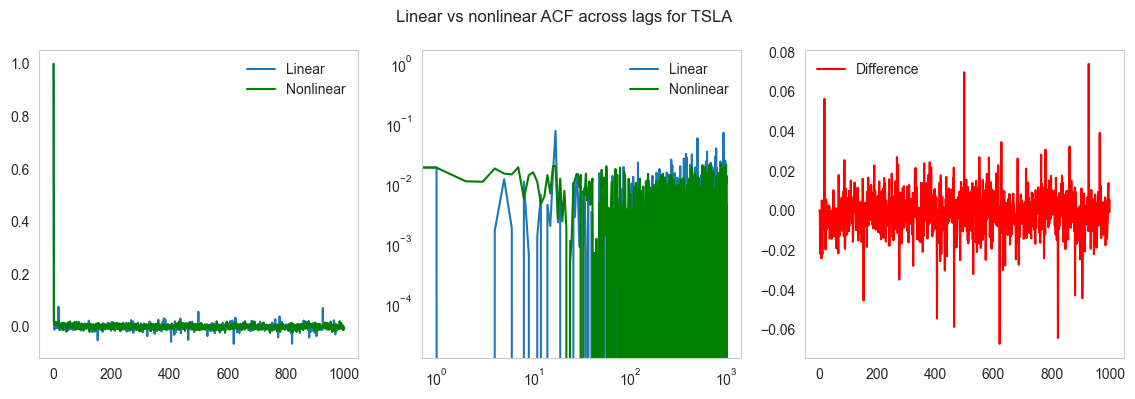

TSLA Max difference: 0.07396830202053141


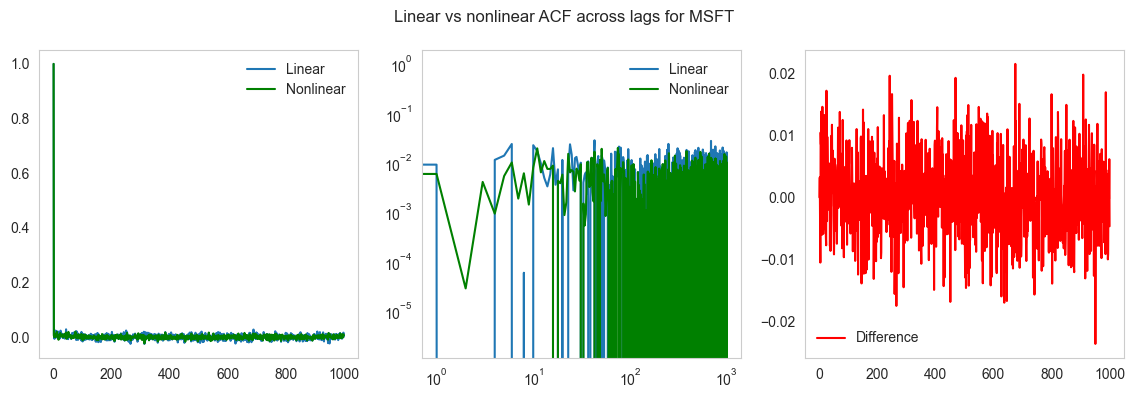

MSFT Max difference: 0.02151438870497143


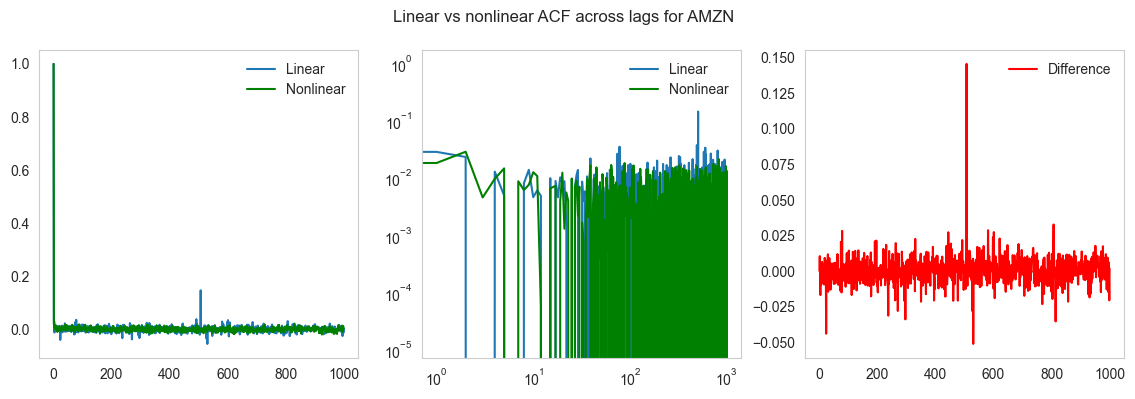

AMZN Max difference: 0.1457396614348206


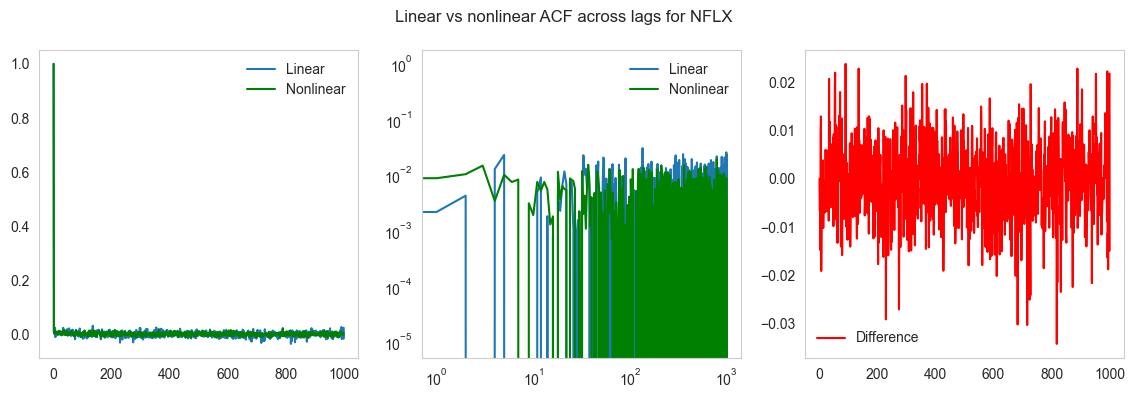

NFLX Max difference: 0.023882959298757885


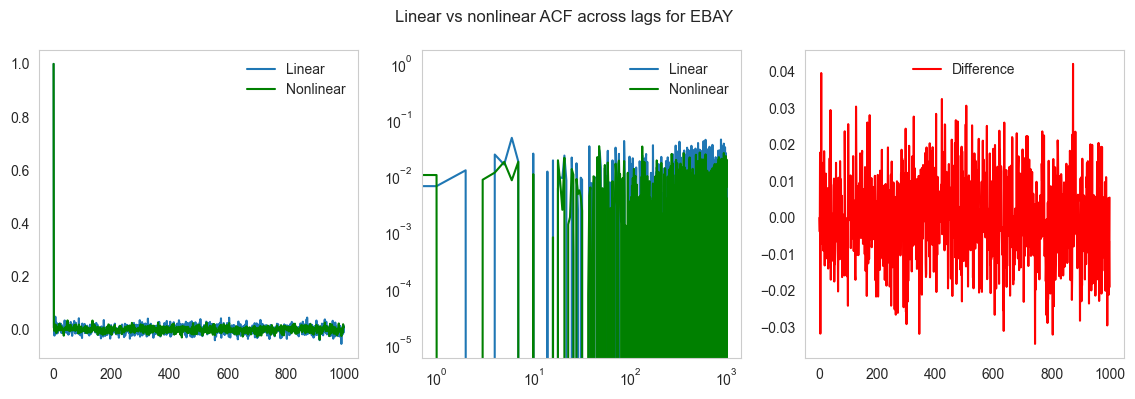

EBAY Max difference: 0.042141325587702824


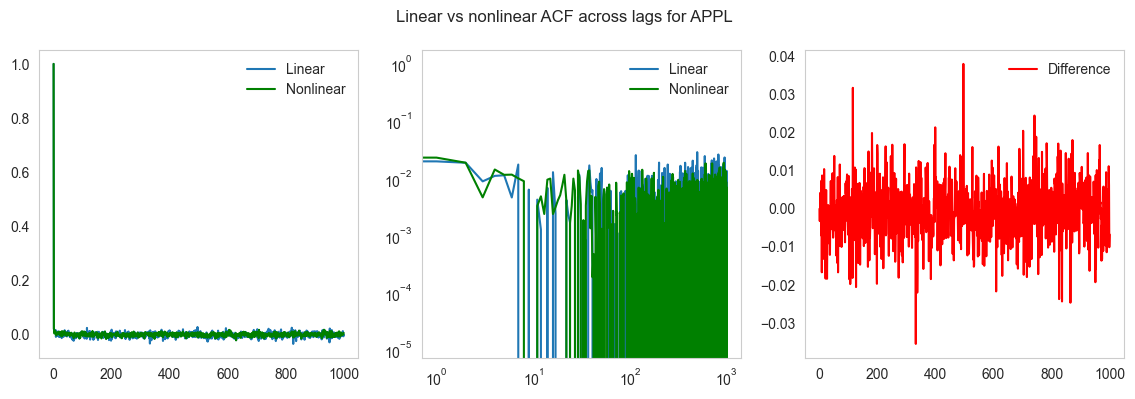

APPL Max difference: 0.03807202736657504


In [31]:
for stock_name in signed_volume_linear_acfs.keys():
    plot_acf_difference(stock_name, signed_volume_linear_acfs, signed_volume_nonlinear_acfs)

### 3.2. Fit power law distribution

In [32]:
# Load the pre-computed ACFs
# 1. Construct values for x- and y-axis of our ACF
def construct_xy(sample: pd.Series, name: str) -> pd.DataFrame:
    y_values = list(sample)
    if len(sample) != len(y_values):
        raise ValueError(f"Sample sizes mismatch for {name}.")

    xy_df = pd.DataFrame({
        'x_values': range(1, len(y_values) + 1),
        'y_values': y_values
    })

    return xy_df

signed_volume_acf_values = {}

for stock, data in signed_volume_nonlinear_acfs.items():
    signed_volume_acf_values[stock] = construct_xy(data, stock)

In [44]:
# Using signs_nonlinear_acfs
signed_volume_fit_results_list = []
signed_volume_fit_objects = {}  # Dictionary to store fit objects

for stock, data in signed_volume_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data)
    if fit_dict:
        signed_volume_fit_results_list.append(fit_dict)
        signed_volume_fit_objects[stock] = fit_obj  # Store the fit object

signed_volume_fit_results = pd.DataFrame(signed_volume_fit_results_list)
display(signed_volume_fit_results.head())

cannot unpack non-iterable NoneType object
cannot unpack non-iterable NoneType object


,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 2.3566588...",27,28.0,0.481520,-9466.807363,113.188964,0.017708,-1.632526,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0008493...",859,860.0,0.514085,-1493.345185,129.061444,-0.021740,-0.000181,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -170756.8...",663,664.0,0.488166,-3365.203865,108.709382,-0.006573,-3.004496,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -3.222947...",106,107.0,0.459218,-9302.495082,115.411663,-0.000068,1.165116,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -7.906960...",19,20.0,0.515275,-9101.101755,105.127817,-0.002657,0.868277,EBAY


In [34]:
print(signed_volume_fit_objects.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


In [35]:
avg_alpha = signed_volume_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -0.5524886412532961


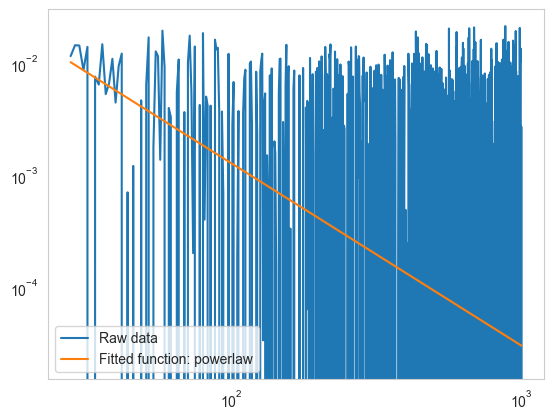

In [43]:
tsla_acf_fit = signed_volume_fit_objects['TSLA']
tsla_acf_fit.powerlaw.plot_fit()

### 3.3. Signed Volume Hurst Exponents

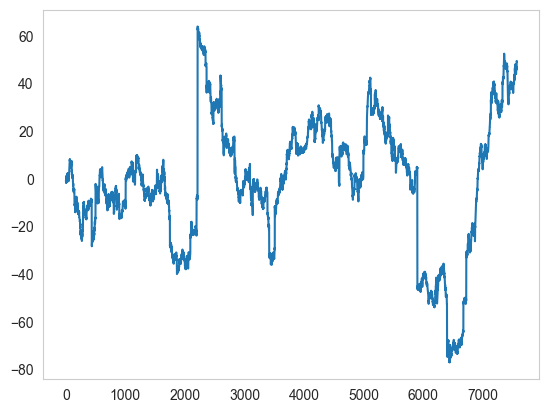

In [58]:
# Compute cumsum of signed volumes
cumsum_signed_volume = {
  'TSLA': tsla_aggregate_orderflow['signed_volume'].cumsum(),
  'MSFT': msft_aggregate_orderflow['signed_volume'].cumsum(),
  'AMZN': amzn_aggregate_orderflow['signed_volume'].cumsum(),
  'NFLX': nflx_aggregate_orderflow['signed_volume'].cumsum(),
  'EBAY': ebay_aggregate_orderflow['signed_volume'].cumsum(),
  'APPL': appl_aggregate_orderflow['signed_volume'].cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
# cumsum_signed_volume = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_signed_volume.items()}
tsla_cumsum_signed_volume = tsla_aggregate_orderflow['signed_volume'].cumsum()
x = list(range(1, len(tsla_cumsum_signed_volume)+1))
plt.plot(x, tsla_cumsum_signed_volume)
plt.grid(False)
plt.show()

#### Standard Hurst

In [59]:
# Standard Hurst
method = 'standard'
signed_volume_fit_results_list = []
signed_volume_fit_objects = {}

for stock, data in cumsum_signed_volume.items():
    fit_dict, fit = compute_hurst_exponent('signed volume', stock, data, method=method)
    if fit_dict:
        signed_volume_fit_results_list.append(fit_dict)
        signed_volume_fit_objects[(stock, method, 'signed volume')] = fit

signed_volume_std_hurst_fit_results = pd.DataFrame(signed_volume_fit_results_list)
display(signed_volume_std_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.3852575...",1,2.0,0.034884,-157.791748,2.577157,0.990092,0.531831,TSLA,signs
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.2241998...",1,1.0,0.040984,-665.114073,2.485231,0.995182,0.605377,MSFT,signs
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.9659928...",1,2.0,0.050505,-283.505846,2.161259,0.993085,0.539746,AMZN,signs
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.8644455...",1,1.0,0.047619,-362.012639,2.753923,0.994075,0.574919,NFLX,signs
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.2308822...",1,2.0,0.056338,-345.283165,2.838724,0.986025,0.550043,EBAY,signs


In [60]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = signed_volume_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.5531050673018297


#### Generalized Hurst

In [46]:
# Generalized Hurst
method = 'generalized'
signed_volume_fit_results_list = []
signed_volume_fit_objects = {}

for stock, data in cumsum_signed_volume.items():
    fit_dict, fit = compute_hurst_exponent('signed_volume', stock, data, method=method, fitting_method = "Least_squares")
    if fit_dict:
        signed_volume_fit_results_list.append(fit_dict)
        signed_volume_fit_objects[(stock, method, 'signed_volume')] = fit

signed_volume_gen_hurst_fit_results = pd.DataFrame(signed_volume_fit_results_list)
display(signed_volume_gen_hurst_fit_results.head())

/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/po

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.6993352...",35,41.0,0.019231,-482.725019,0.076941,0.999954,0.595628,TSLA,signed volume
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1475337...",1,1.0,0.016393,-1037.831244,1.192630,0.999656,0.645895,MSFT,signed volume
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.4864850...",31,32.0,0.014493,-709.743108,0.068257,0.999983,0.632190,AMZN,signed volume
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.4747174...",1,1.0,0.015873,-920.490813,0.591940,0.999880,0.637719,NFLX,signed volume
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1593181...",1,2.0,0.028169,-630.518184,0.732966,0.999657,0.591426,EBAY,signed volume


In [47]:
# Generalized Hurst statistic across stocks
min_hurst_gen = signed_volume_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = signed_volume_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = signed_volume_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = signed_volume_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.5914141115117391
Max Generalized Hurst: 0.6458953578300244
Average Generalized Hurst: 0.6157120795446294
Standard_dev Generalized Hurst: 0.02549667683046655


In [48]:
print(signed_volume_fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'signed volume'), ('MSFT', 'generalized', 'signed volume'), ('AMZN', 'generalized', 'signed volume'), ('NFLX', 'generalized', 'signed volume'), ('EBAY', 'generalized', 'signed volume'), ('APPL', 'generalized', 'signed volume')])


## 4. Signed Ordeflow Imbalance

In [5]:
# Aggregate orderflow
tsla_aggregate_orderflow = get_agg_features(tsla_raw_df, [LAG], remove_outliers=False)
msft_aggregate_orderflow = get_agg_features(msft_raw_df, [LAG], remove_outliers=False)
amzn_aggregate_orderflow = get_agg_features(amzn_raw_df, [LAG], remove_outliers=False)
nflx_aggregate_orderflow = get_agg_features(nflx_raw_df, [LAG],remove_outliers=False)
ebay_aggregate_orderflow = get_agg_features(ebay_raw_df, [LAG], remove_outliers=False)
appl_aggregate_orderflow = get_agg_features(appl_raw_df, [LAG],remove_outliers=False)

# Order Sign imbalance
sign_imbalance = {
  'TSLA': tsla_aggregate_orderflow['sign_imbalance'],
  'MSFT': msft_aggregate_orderflow['sign_imbalance'],
  'AMZN': amzn_aggregate_orderflow['sign_imbalance'],
  'NFLX': nflx_aggregate_orderflow['sign_imbalance'],
  'EBAY': ebay_aggregate_orderflow['sign_imbalance'],
  'APPL': appl_aggregate_orderflow['sign_imbalance']
}

# Sign Volume Imbalance
volume_imbalance = {
 'TSLA': tsla_aggregate_orderflow['vol_imbalance'],
 'MSFT': msft_aggregate_orderflow['vol_imbalance'],
 'AMZN': amzn_aggregate_orderflow['vol_imbalance'],
 'NFLX': nflx_aggregate_orderflow['vol_imbalance'],
 'EBAY': ebay_aggregate_orderflow['vol_imbalance'],
 'APPL': appl_aggregate_orderflow['vol_imbalance']
}

#### Stationarity Test

In [ ]:
# Sign imbalance ADF test
for stock, data in sign_imbalance.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

In [ ]:
# Volume imbalance ADF test
for stock, data in volume_imbalance.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

### 4.1. Order sign imbalance long memory

In [6]:
# Linear ACF
sign_imbalance_linear_acf_filename = f"{acf_data_dir}/mo_sign_imbalance_linear_acfs.pkl"
sign_imbalance_linear_acfs = compute_acfs(filename=sign_imbalance_linear_acf_filename, data=sign_imbalance, option='linear')
print(sign_imbalance_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


In [8]:
# Nonlinear ACF
sign_imbalance_nonlinear_acf_filename = f"{acf_data_dir}/mo_sign_imbalance_nonlinear_acfs.pkl"
sign_imbalance_nonlinear_acfs = compute_acfs(filename=sign_imbalance_nonlinear_acf_filename, data=sign_imbalance, option='nonlinear')
print(sign_imbalance_nonlinear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


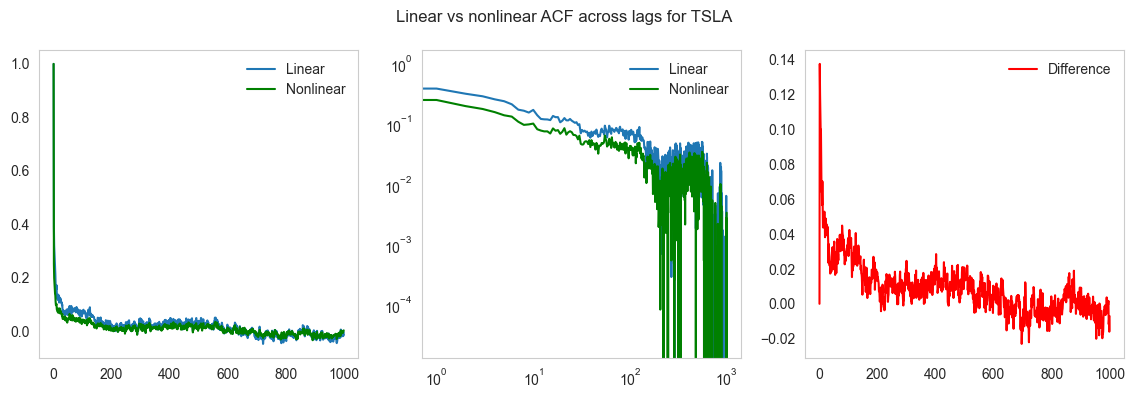

TSLA Max difference: 0.13761022295218567


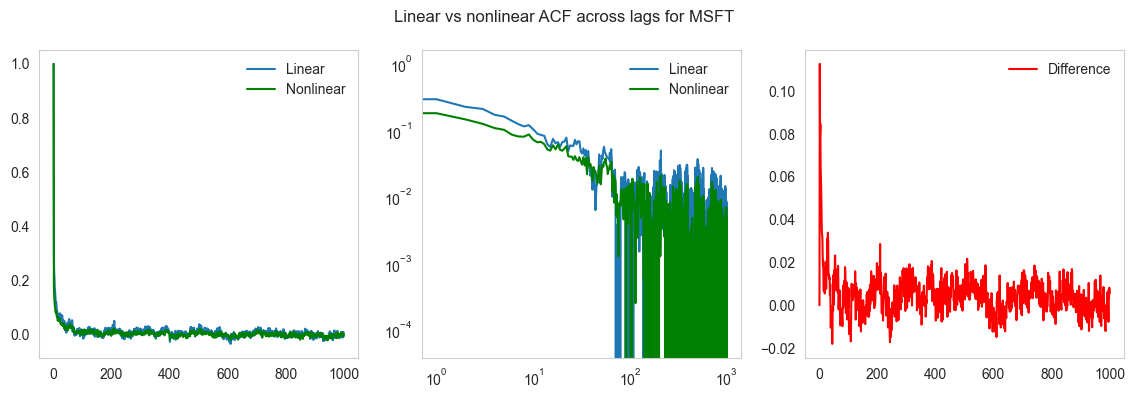

MSFT Max difference: 0.11272272494103669


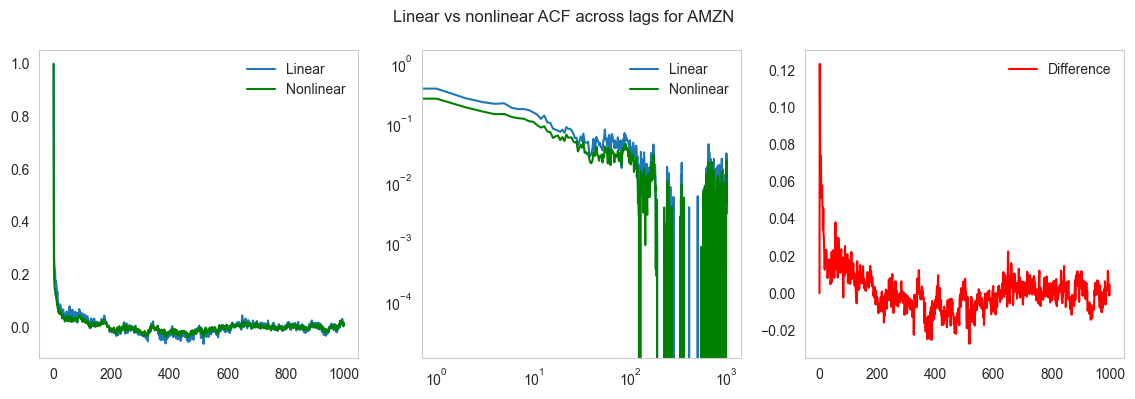

AMZN Max difference: 0.12343655176436069


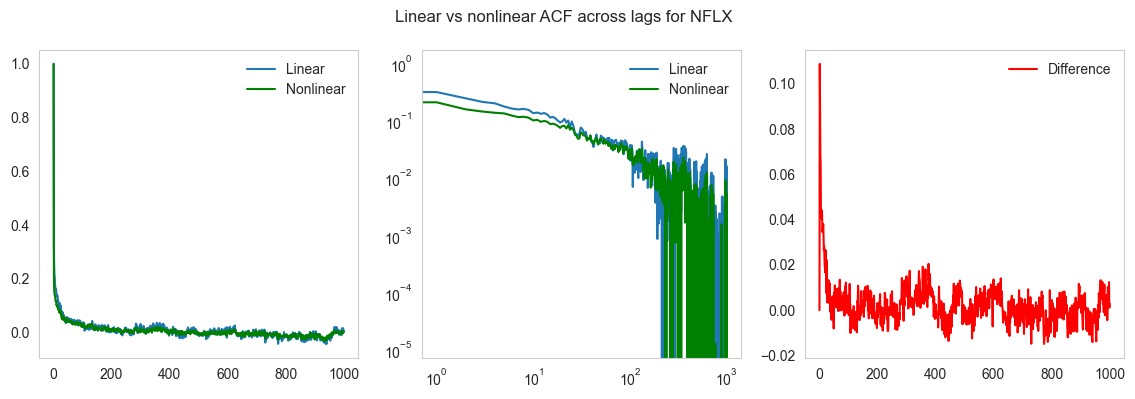

NFLX Max difference: 0.10871449122484297


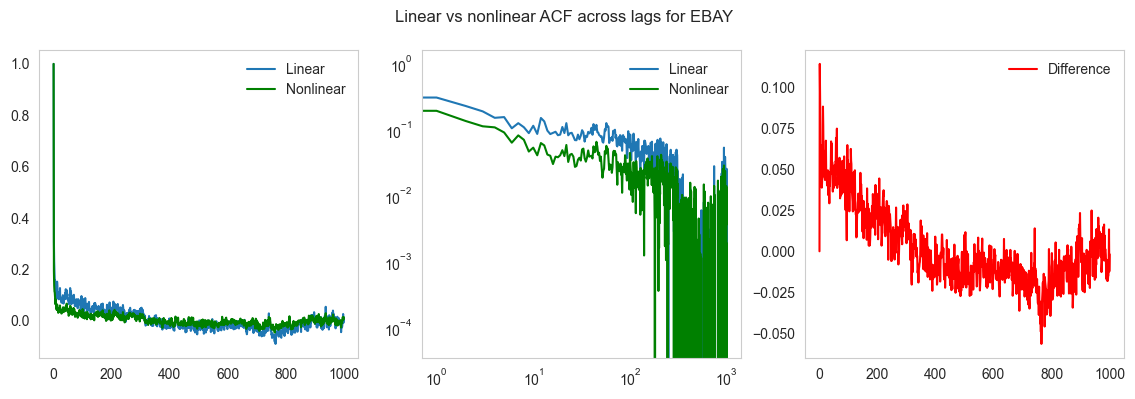

EBAY Max difference: 0.11463905974581148


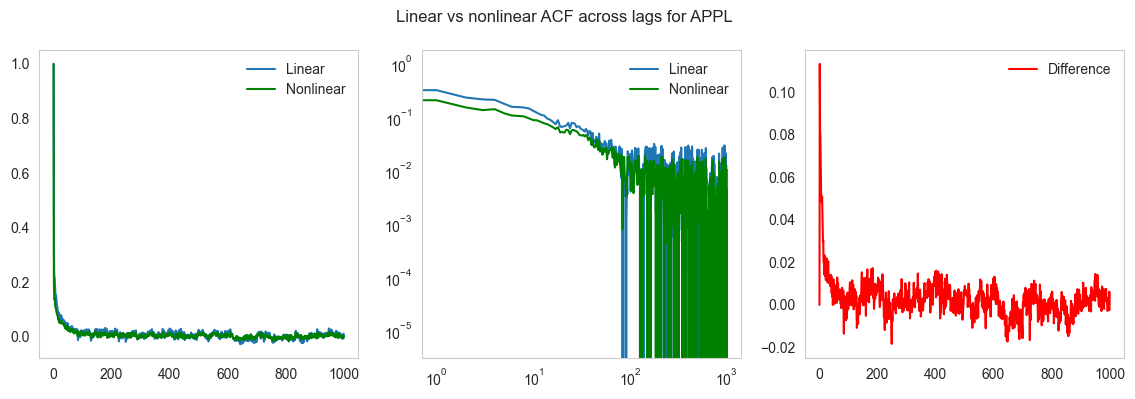

APPL Max difference: 0.11338497202561168


In [9]:
for stock_name in sign_imbalance_linear_acfs.keys():
    plot_acf_difference(stock_name, sign_imbalance_linear_acfs, sign_imbalance_nonlinear_acfs)

#### 4.1.1. Fit power law distribution

In [10]:
# Load the pre-computed ACFs
# 1. Construct values for x- and y-axis of our ACF
def construct_xy(sample: pd.Series, name: str) -> pd.DataFrame:
    y_values = list(sample)
    if len(sample) != len(y_values):
        raise ValueError(f"Sample sizes mismatch for {name}.")

    xy_df = pd.DataFrame({
        'x_values': range(1, len(y_values) + 1),
        'y_values': y_values
    })

    return xy_df

sign_imbalance_acf_values = {}

for stock, data in sign_imbalance_nonlinear_acfs.items():
    sign_imbalance_acf_values[stock] = construct_xy(data, stock)

In [20]:
# Using signs_imbalance_nonlinear_acfs
sign_imbalance_fit_results_list = []
sign_imbalance_fit_objects = {}  # Dictionary to store fit objects

for stock, data in sign_imbalance_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data, xmin_index=10)
    if fit_dict:
        sign_imbalance_fit_results_list.append(fit_dict)
        sign_imbalance_fit_objects[stock] = fit_obj  # Store the fit object

sign_imbalance_fit_results = pd.DataFrame(sign_imbalance_fit_results_list)
display(sign_imbalance_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.7472006...",10,11.0,0.417760,-8466.614894,199.379750,0.555156,-0.743923,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.0647695...",10,11.0,0.482341,-9737.116062,170.661660,0.599804,-1.032763,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -2.441892...",10,11.0,0.461150,-7987.395369,146.679125,0.019623,0.743281,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.4896302...",10,11.0,0.526741,-9015.253876,216.684596,0.686286,-0.973960,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.7699439...",10,11.0,0.565086,-8246.485215,134.830579,0.320658,-0.897415,EBAY


In [21]:
print(sign_imbalance_fit_objects.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


In [22]:
avg_alpha = sign_imbalance_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -0.6460722323251281


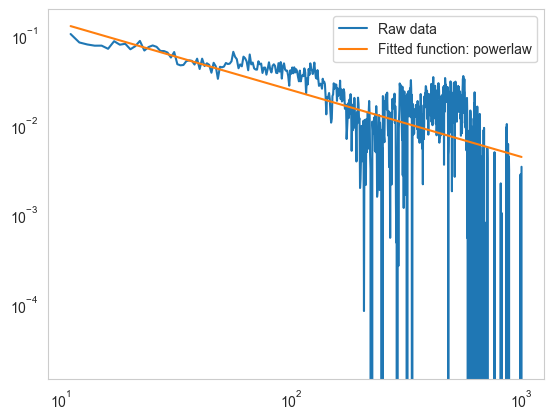

In [24]:
tsla_acf_fit = sign_imbalance_fit_objects['TSLA']
tsla_acf_fit.powerlaw.plot_fit()

#### 4.1.2. Sign Imbalance Hurst Exponents

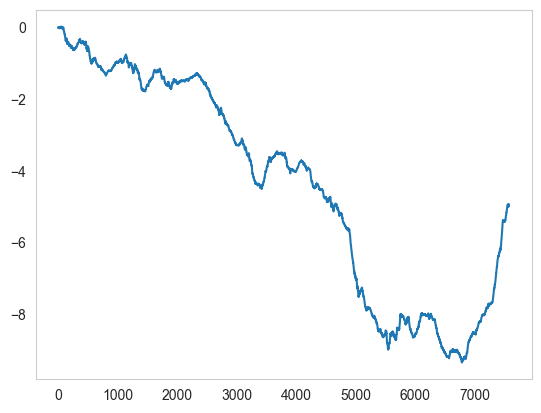

In [7]:
# Compute cumsum of order sign imbalance
cumsum_sign_imbalance = {
  'TSLA': tsla_aggregate_orderflow['sign_imbalance'].cumsum(),
  'MSFT': msft_aggregate_orderflow['sign_imbalance'].cumsum(),
  'AMZN': amzn_aggregate_orderflow['sign_imbalance'].cumsum(),
  'NFLX': nflx_aggregate_orderflow['sign_imbalance'].cumsum(),
  'EBAY': ebay_aggregate_orderflow['sign_imbalance'].cumsum(),
  'APPL': appl_aggregate_orderflow['sign_imbalance']
}
tsla_cumsum_sign_imbalance = tsla_aggregate_orderflow['sign_imbalance'].cumsum()
x = list(range(1, len(tsla_cumsum_sign_imbalance)+1))
plt.plot(x, tsla_cumsum_sign_imbalance)
plt.grid(False)
plt.show()

##### Standard Hurst

In [17]:
# Standard Hurst
method = 'standard'
sign_imbalance_fit_results_list = []
sign_imbalance_fit_objects = {}

for stock, data in cumsum_sign_imbalance.items():
    fit_dict, fit = compute_hurst_exponent('sign_imbalance', stock, data, method=method)
    if fit_dict:
        sign_imbalance_fit_results_list.append(fit_dict)
        sign_imbalance_fit_objects[(stock, method, 'signs_imbalance')] = fit

sign_imbalance_std_hurst_fit_results = pd.DataFrame(sign_imbalance_fit_results_list)
display(sign_imbalance_std_hurst_fit_results.head())

/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")


,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0098389...",1,2.0,0.034884,-948.655824,1.343256,0.998489,0.782492,TSLA,signs
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0049727...",1,1.0,0.040984,-1461.816398,1.968203,0.995420,0.714461,MSFT,signs
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0085942...",1,2.0,0.020202,-1149.368913,1.708396,0.998131,0.731729,AMZN,signs
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0040222...",1,1.0,0.031746,-1656.411312,1.887632,0.998362,0.743267,NFLX,signs
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0108987...",1,2.0,0.042254,-677.676237,2.849012,0.996702,0.832562,EBAY,signs


In [18]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = sign_imbalance_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.6395340232369439


##### Generalized Hurst

In [12]:
# Generalized Hurst
method = 'generalized'
sign_imbalance_fit_results_list = []
sign_imbalance_fit_objects = {}

for stock, data in cumsum_sign_imbalance.items():
    fit_dict, fit = compute_hurst_exponent('signed_imbalance', stock, data, method=method, fitting_method = "Least_squares")
    if fit_dict:
        sign_imbalance_fit_results_list.append(fit_dict)
        sign_imbalance_fit_objects[(stock, method, 'signed_imbalance')] = fit

sign_imbalance_gen_hurst_fit_results = pd.DataFrame(sign_imbalance_fit_results_list)
display(sign_imbalance_gen_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0070439...",1,2.0,0.011628,-1252.362932,0.303776,0.999927,0.799303,TSLA,signed_volume
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0031705...",1,1.0,0.016393,-1972.047719,0.694806,0.999877,0.747961,MSFT,signed_volume
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0064234...",1,2.0,0.010101,-1454.966357,0.859822,0.999866,0.745187,AMZN,signed_volume
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0029079...",1,1.0,0.015873,-2000.092411,1.056268,0.999829,0.761483,NFLX,signed_volume
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0078681...",1,2.0,0.028169,-871.786224,2.014182,0.999429,0.799752,EBAY,signed_volume


In [13]:
# Generalized Hurst statistic across stocks
min_hurst_gen = sign_imbalance_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = sign_imbalance_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = sign_imbalance_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = sign_imbalance_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.036261795112901576
Max Generalized Hurst: 0.7997518302856402
Average Generalized Hurst: 0.6483246421922332
Standard_dev Generalized Hurst: 0.300818953208582


In [14]:
print(sign_imbalance_fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'signed_volume'), ('MSFT', 'generalized', 'signed_volume'), ('AMZN', 'generalized', 'signed_volume'), ('NFLX', 'generalized', 'signed_volume'), ('EBAY', 'generalized', 'signed_volume'), ('APPL', 'generalized', 'signed_volume')])


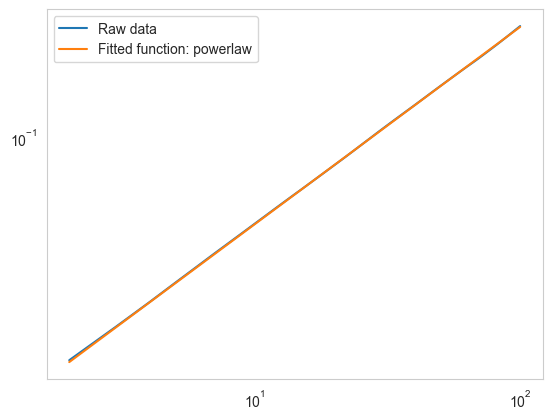

In [16]:
# Retrieve standard Hurst fit object for specific 'STOCK'
tsla_generalized_fit = sign_imbalance_fit_objects[('TSLA', 'generalized', 'signed_volume')]
tsla_generalized_fit.powerlaw.plot_fit()

### 4.2. Signed Volume imbalance long memory

In [6]:
# Linear ACF
volume_imbalance_linear_acf_filename = f"{acf_data_dir}/mo_volume_imbalance_linear_acfs.pkl"
volume_imbalance_linear_acfs = compute_acfs(filename=volume_imbalance_linear_acf_filename, data=volume_imbalance, option='linear')
print(volume_imbalance_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


In [7]:
# Nonlinear ACF
volume_imbalance_nonlinear_acf_filename = f"{acf_data_dir}/mo_volume_imbalance_nonlinear_acfs.pkl"
volume_imbalance_nonlinear_acfs = compute_acfs(filename=volume_imbalance_nonlinear_acf_filename, data=volume_imbalance, option='nonlinear')
print(volume_imbalance_nonlinear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


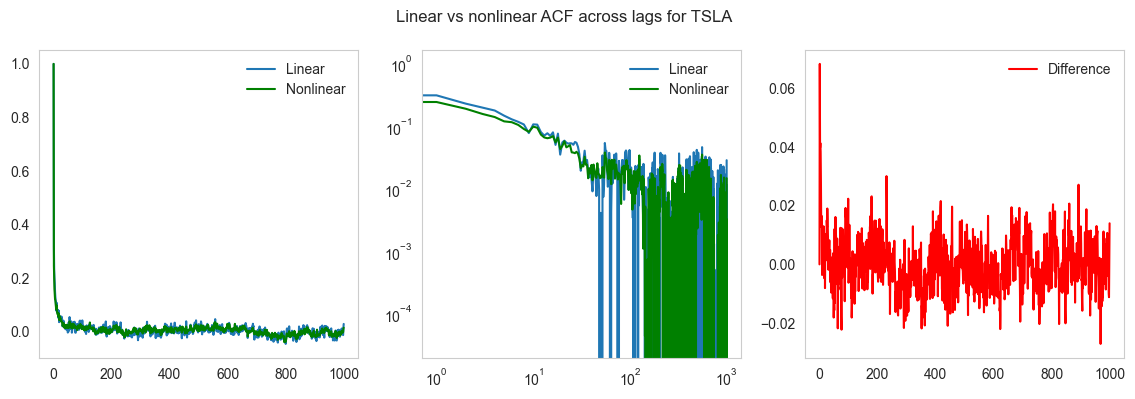

TSLA Max difference: 0.06845219943428177


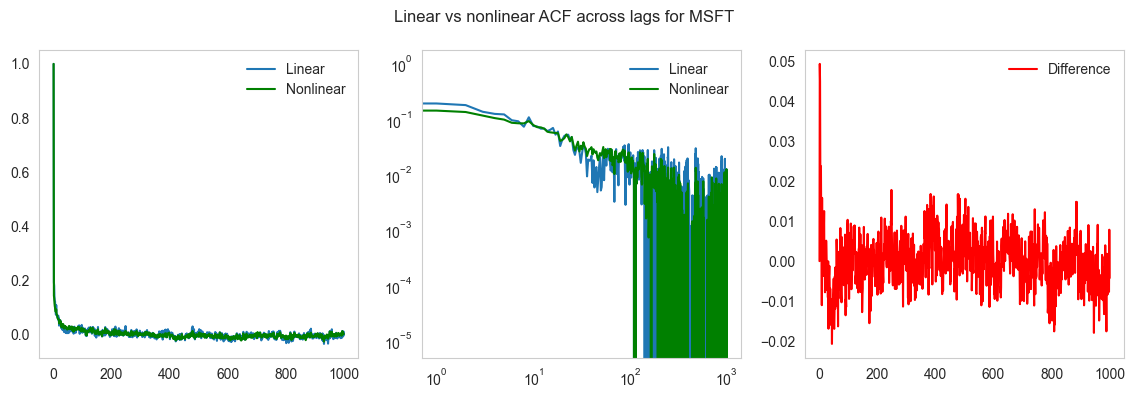

MSFT Max difference: 0.049449900122835594


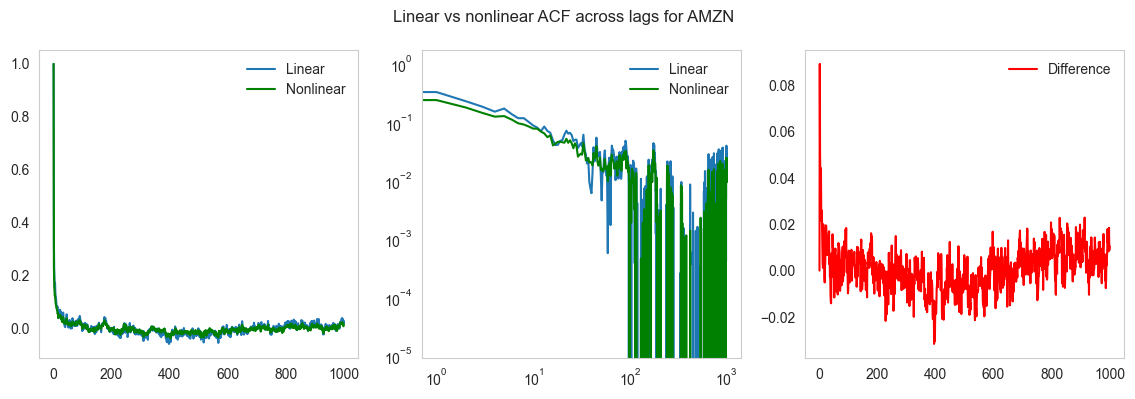

AMZN Max difference: 0.08922314322739258


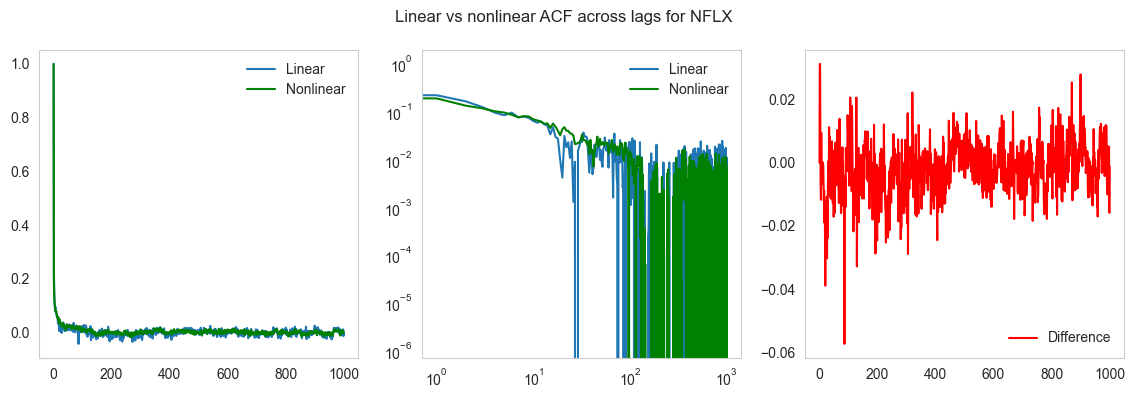

NFLX Max difference: 0.031165752496182253


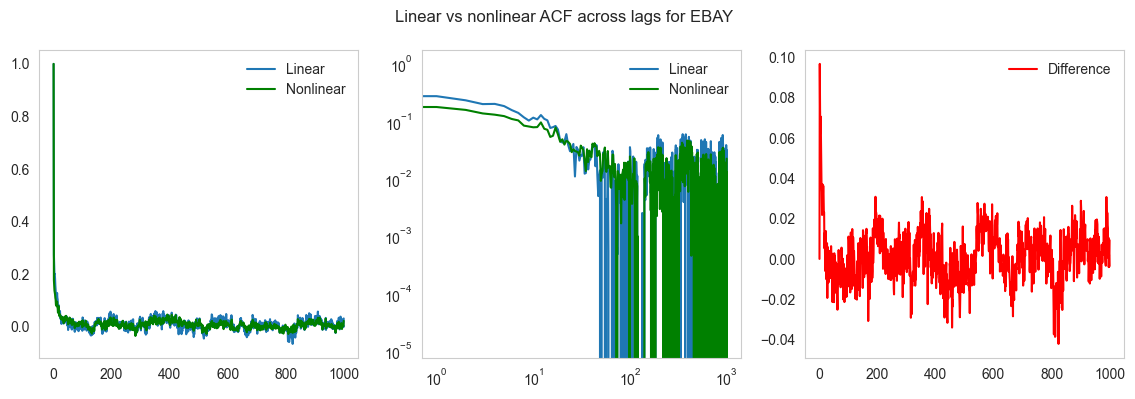

EBAY Max difference: 0.0967358723911432


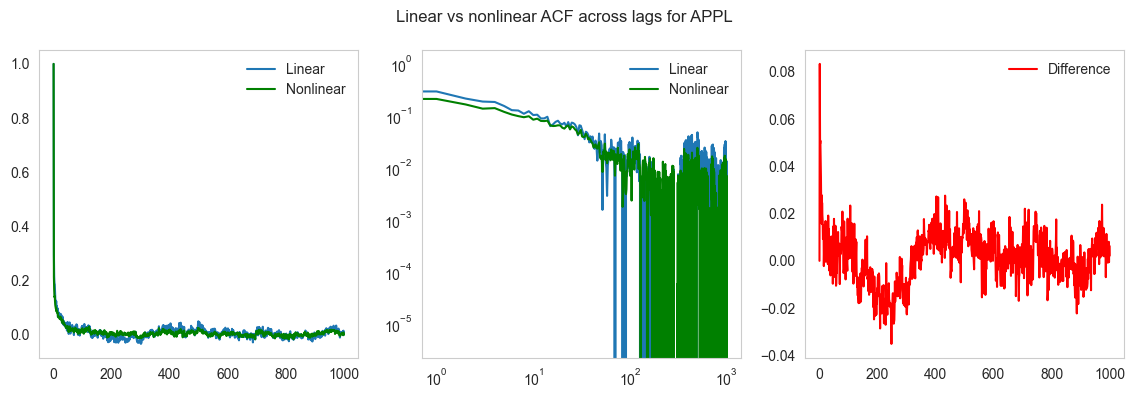

APPL Max difference: 0.08326959370071826


In [8]:
for stock_name in volume_imbalance_linear_acfs.keys():
    plot_acf_difference(stock_name, volume_imbalance_linear_acfs, volume_imbalance_nonlinear_acfs)

#### 4.2.1. Fit power law distribution

In [9]:
# Load the pre-computed ACFs
# 1. Construct values for x- and y-axis of our ACF
def construct_xy(sample: pd.Series, name: str) -> pd.DataFrame:
    y_values = list(sample)
    if len(sample) != len(y_values):
        raise ValueError(f"Sample sizes mismatch for {name}.")

    xy_df = pd.DataFrame({
        'x_values': range(1, len(y_values) + 1),
        'y_values': y_values
    })

    return xy_df

volume_imbalance_acf_values = {}

for stock, data in volume_imbalance_nonlinear_acfs.items():
    volume_imbalance_acf_values[stock] = construct_xy(data, stock)

In [10]:
# Using signs_imbalance_nonlinear_acfs
volume_imbalance_fit_results_list = []
volume_imbalance_fit_objects = {}  # Dictionary to store fit objects

for stock, data in volume_imbalance_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data, xmin_index=10)
    if fit_dict:
        volume_imbalance_fit_results_list.append(fit_dict)
        volume_imbalance_fit_objects[stock] = fit_obj  # Store the fit object

volume_imbalance_fit_results = pd.DataFrame(volume_imbalance_fit_results_list)
display(volume_imbalance_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.9117123...",10,11.0,0.398587,-8880.576333,175.817198,0.420725,-0.946230,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.5231074...",10,11.0,0.610494,-9442.617769,216.035782,0.557865,-1.146584,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -6.373826...",10,11.0,0.482341,-8390.982494,178.362506,0.011093,0.534847,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.3761411...",10,11.0,0.509586,-9976.839255,151.445195,0.574036,-1.174604,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.3771149...",10,11.0,0.358224,-8625.488549,10907.891810,0.244487,-0.694165,EBAY


In [11]:
print(volume_imbalance_fit_objects.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


In [12]:
avg_alpha = volume_imbalance_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -0.7433390038612474


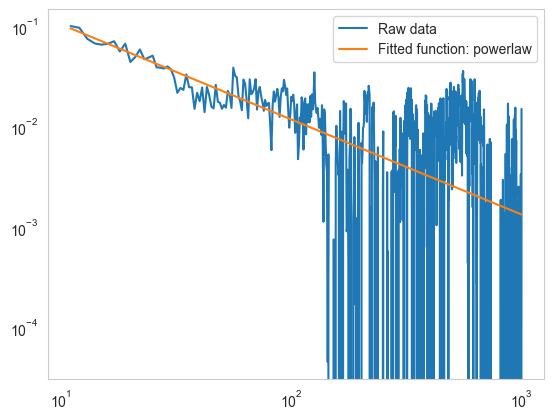

In [15]:
tsla_acf_fit = volume_imbalance_fit_objects['TSLA']
tsla_acf_fit.powerlaw.plot_fit()

#### 4.2.2. Volume Imbalance Hurst Exponents

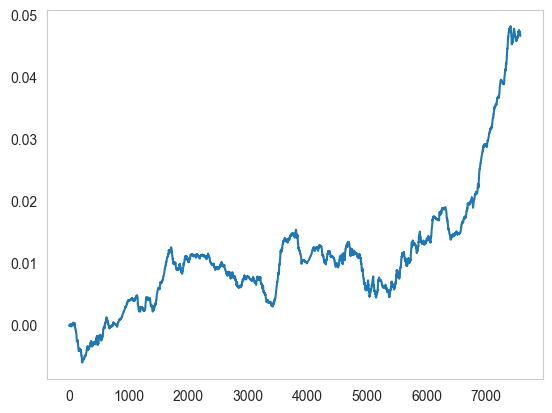

In [16]:
# Compute cumsum of order sign imbalance
cumsum_volume_imbalance = {
 'TSLA': tsla_aggregate_orderflow['vol_imbalance'].cumsum(),
 'MSFT': msft_aggregate_orderflow['vol_imbalance'].cumsum(),
 'AMZN': amzn_aggregate_orderflow['vol_imbalance'].cumsum(),
 'NFLX': nflx_aggregate_orderflow['vol_imbalance'].cumsum(),
 'EBAY': ebay_aggregate_orderflow['vol_imbalance'].cumsum(),
 'APPL': appl_aggregate_orderflow['vol_imbalance']
}
tsla_cumsum_volume_imbalance = tsla_aggregate_orderflow['vol_imbalance'].cumsum()
x = list(range(1, len(tsla_cumsum_volume_imbalance)+1))
plt.plot(x, tsla_cumsum_volume_imbalance)
plt.grid(False)
plt.show()

##### Standard Hurst

In [18]:
# Standard Hurst
method = 'standard'
volume_imbalance_fit_results_list = []
voliume_imbalance_fit_objects = {}

for stock, data in cumsum_volume_imbalance.items():
    fit_dict, fit = compute_hurst_exponent('volume_imbalance', stock, data, method=method)
    if fit_dict:
        volume_imbalance_fit_results_list.append(fit_dict)
        voliume_imbalance_fit_objects[(stock, method, 'volume_imbalance')] = fit

volume_imbalance_std_hurst_fit_results = pd.DataFrame(volume_imbalance_fit_results_list)
display(volume_imbalance_std_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 9.4910205...",1,2.0,0.034884,-1717.993191,2.589625,0.994765,0.691162,TSLA,volume_imbalance
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.8375841...",1,1.0,0.040984,-3544.511432,1.760747,0.998270,0.685643,MSFT,volume_imbalance
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 8.9779296...",1,2.0,0.030303,-2020.843410,2.023551,0.996124,0.690948,AMZN,volume_imbalance
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 2.7057969...",1,1.0,0.031746,-2961.732468,1.985963,0.997039,0.649985,NFLX,volume_imbalance
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 4.5939596...",1,2.0,0.042254,-1848.874368,3.344250,0.994205,0.678266,EBAY,volume_imbalance


In [19]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = volume_imbalance_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.5689139307461707


##### Generalized Hurst

In [24]:
# Generalized Hurst
method = 'generalized'
volume_imbalance_fit_results_list = []
volume_imbalance_fit_objects = {}

for stock, data in cumsum_volume_imbalance.items():
    fit_dict, fit = compute_hurst_exponent('volume_imbalance', stock, data, method=method)
    if fit_dict:
        volume_imbalance_fit_results_list.append(fit_dict)
        volume_imbalance_fit_objects[(stock, method, 'volume_imbalance')] = fit

volume_imbalance_gen_hurst_fit_results = pd.DataFrame(volume_imbalance_fit_results_list)
display(volume_imbalance_gen_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 6.9027068...",1,2.0,0.011628,-2028.437553,1.297237,0.999764,0.704170,TSLA,volume_imbalance
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.1461254...",1,1.0,0.016393,-4016.641090,0.374970,0.999954,0.756983,MSFT,volume_imbalance
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 5.5951787...",1,2.0,0.010101,-2557.271477,0.315180,0.999975,0.748076,AMZN,volume_imbalance
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.7313667...",1,1.0,0.015873,-3395.130560,0.993440,0.999851,0.693225,NFLX,volume_imbalance
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 3.3382886...",1,2.0,0.028169,-2000.280058,2.612399,0.998885,0.693263,EBAY,volume_imbalance


In [25]:
# Generalized Hurst statistic across stocks
min_hurst_gen = volume_imbalance_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = volume_imbalance_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = volume_imbalance_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = volume_imbalance_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.03710278064302332
Max Generalized Hurst: 0.7569830333492142
Average Generalized Hurst: 0.6054697629715667
Standard_dev Generalized Hurst: 0.2798156382624879


In [26]:
print(volume_imbalance_fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'volume_imbalance'), ('MSFT', 'generalized', 'volume_imbalance'), ('AMZN', 'generalized', 'volume_imbalance'), ('NFLX', 'generalized', 'volume_imbalance'), ('EBAY', 'generalized', 'volume_imbalance'), ('APPL', 'generalized', 'volume_imbalance')])


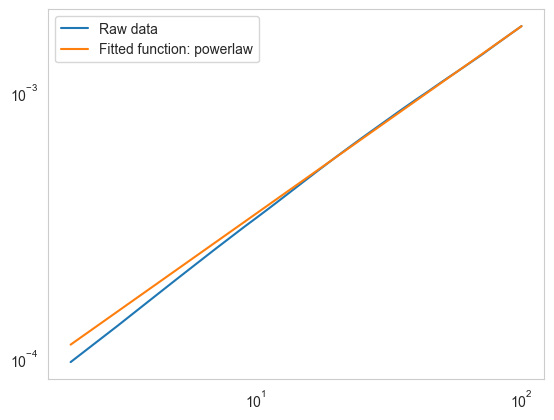

In [28]:
# Retrieve standard Hurst fit object for specific 'STOCK'
tsla_generalized_fit = volume_imbalance_fit_objects[('TSLA', 'generalized', 'volume_imbalance')]
tsla_generalized_fit.powerlaw.plot_fit()